# Testing with sklearn models

In [1]:
from pathlib import Path
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys 

sys.path.append("..")
from src.models.data import CropDataset, BoundingBox
from src.datasets_labeled import labeled_datasets

In [2]:
# Load validation dataset (tensors)
datasets = [d for d in labeled_datasets]
train = CropDataset(
    data_folder=Path("../data"),
    subset="training",
    datasets=datasets,
    cache=None,
    noise_factor=0,
    probability_threshold=0.5,
    remove_b1_b10=True,
    upsample=False,
    target_bbox=BoundingBox(min_lon=-180, max_lon=180, min_lat=-90, max_lat=90),
    is_local_only=False,
    is_global_only=False,
)

Directory: ../data/features/Ethiopia_Tigray_2020/training not found. Use command: `dvc pull` to get the latest data.
Directory: ../data/features/Ethiopia_Tigray_2021/training not found. Use command: `dvc pull` to get the latest data.
100%|██████████| 67709/67709 [00:25<00:00, 2632.91it/s]


In [10]:
def generate_validation_X_y(labeled_dataset):
    d = CropDataset(
        data_folder=Path("../data"),
        subset="validation",
        datasets=[labeled_dataset],
        cache=None,
        noise_factor=0,
        probability_threshold=0.5,
        remove_b1_b10=True,
        normalizing_dict=train.normalizing_dict,
        upsample=False,
        target_bbox=BoundingBox(min_lon=-180, max_lon=180, min_lat=-90, max_lat=90),
        is_local_only=False,
        is_global_only=False,
    )
    return generate_X_y(d)

In [4]:
def generate_X_y(dataset):
    X = [t[0].numpy().flatten() for t in dataset]
    y = [float(t[1]) for t in dataset]
    return X, y

In [5]:
X_train, y_train = generate_X_y(train)

In [12]:
classifiers = {
    "RandomForest": RandomForestClassifier(),
    "SVC": SVC(),
}

# Fit classifiers
for name, clf in classifiers.items():
    print(f"Fitting: {name}")
    clf.fit(X_train, y_train)

Fitting: RandomForest
Fitting: SVC


In [14]:
results = {}
for d in labeled_datasets:
    if d.dataset not in ["Kenya", "Togo", "Uganda", "Rwanda", "Ethiopia_Tigray_2020"]:
        continue
    results[d.dataset] = {}
    X_val, y_val = generate_validation_X_y(d)
    for name, clf in classifiers.items():
        y_pred = clf.predict(X_val)
        results[d.dataset][name] = f1_score(y_val, y_pred)

In [15]:
pd.DataFrame(results)

,Kenya,Togo,Rwanda,Uganda,Ethiopia_Tigray_2020
RandomForest,0.936426,0.681818,0.527221,0.354839,0.630303
SVC,0.922951,0.610442,0.586538,0.469880,0.638418


# Which datasets help Ethiopia the most?

In [18]:
Ethiopia_dataset = [d for d in labeled_datasets if d.dataset == "Ethiopia_Tigray_2020"][0]
X_val, y_val = generate_validation_X_y(Ethiopia_dataset)

In [19]:
def train_SVC_on_datasets(datasets):
    train_dataset = CropDataset(
        data_folder=Path("../data"),
        subset="training",
        datasets=datasets,
        cache=None,
        noise_factor=0,
        probability_threshold=0.5,
        remove_b1_b10=True,
        upsample=False,
        target_bbox=BoundingBox(min_lon=-180, max_lon=180, min_lat=-90, max_lat=90),
        is_local_only=False,
        is_global_only=False,
    )
    X_train, y_train = generate_X_y(train_dataset)
    svc = SVC()
    try:
        svc.fit(X_train, y_train)
    except:
        return None
    
    return svc

In [ ]:
results = {}
for d in labeled_datasets:
    scv_Ethiopia = train_SVC_on_datasets([d])
    if svc_Ethiopia:
        y_pred = svc_Ethiopia.predict(X_val)
        results[d.dataset] = f1_score(y_val, y_pred)
        print(f"{d.dataset}: {results[d.dataset]}")

In [20]:
def plot_results(res, title):
    sorted_results = {k: v for k, v in sorted(res.items(), key=lambda item: -item[1])}
    plt.bar(sorted_results.keys(), sorted_results.values())
    plt.xticks(rotation = 90);
    plt.title(title)
    plt.xlabel("Training Dataset")
    plt.ylabel("Ethiopia Validation F1 Score")

In [21]:
def train_on_datasets_plus_one(datasets):
    names = "+".join([d.dataset for d in datasets])
    res = {}
    for d in labeled_datasets:
        if d not in datasets:
            svc_Ethiopia = train_SVC_on_datasets(datasets + [d])
            y_pred = svc_Ethiopia.predict(X_val)
            res[f"{d.dataset}"] = f1_score(y_val, y_pred)
    plot_results(res, f"Training: {names}")

Text(0, 0.5, 'Ethiopia Validation F1 Score')

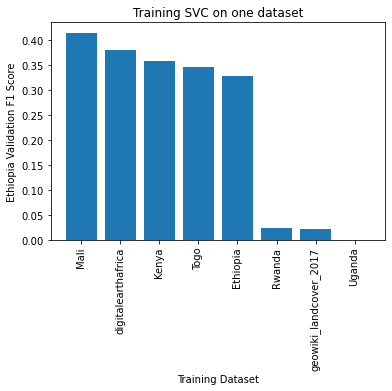

In [42]:
train_on_datasets_plus_one([])
# Training on only Uganda gives a score of 0, why?

Text(0, 0.5, 'Ethiopia Validation F1 Score')

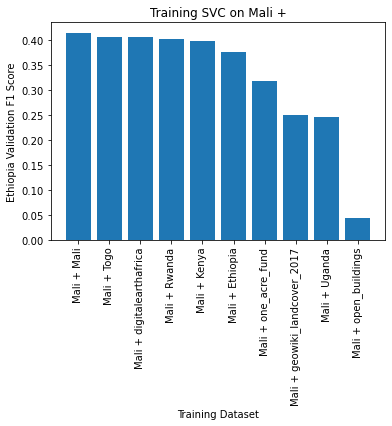

In [93]:
datasets = [d for d in labeled_datasets if d.dataset in ["Mali"]]
train_on_datasets_plus_one(datasets)

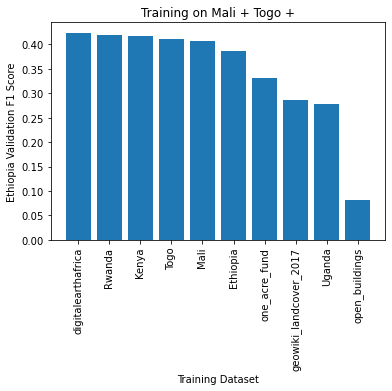

In [106]:
datasets = [d for d in labeled_datasets if d.dataset in ["Mali", "Togo"]]
train_on_datasets_plus_one(datasets)

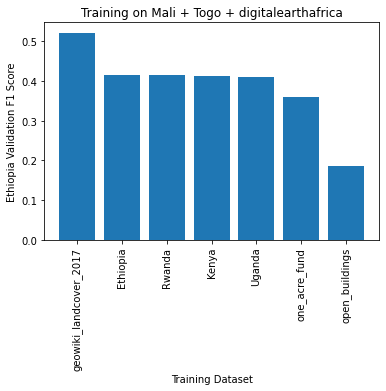

In [109]:
datasets = [d for d in labeled_datasets if d.dataset in ["Mali", "Togo", "digitalearthafrica"]]
train_on_datasets_plus_one(datasets)

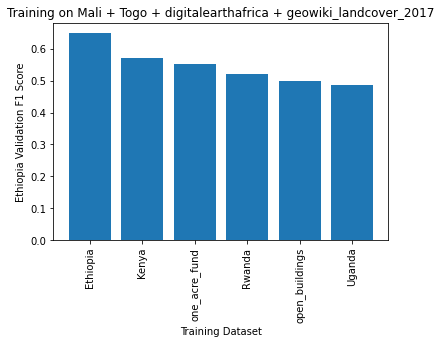

In [112]:
datasets = [d for d in labeled_datasets if d.dataset in ["Mali", "Togo", "digitalearthafrica", "geowiki_landcover_2017"]]
train_on_datasets_plus_one(datasets)

100%|██████████| 53411/53411 [00:16<00:00, 3303.09it/s]


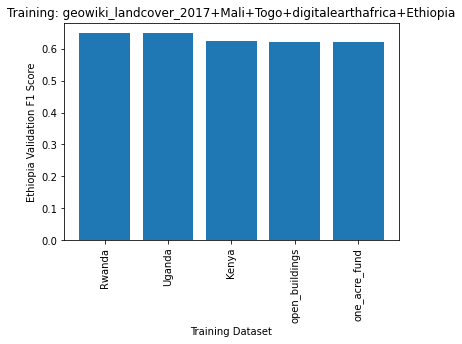

In [124]:
datasets = [d for d in labeled_datasets if d.dataset in [
    "Mali", "Togo", "digitalearthafrica", "geowiki_landcover_2017", "Ethiopia"
]]
train_on_datasets_plus_one(datasets)

100%|██████████| 53698/53698 [00:22<00:00, 2390.57it/s]


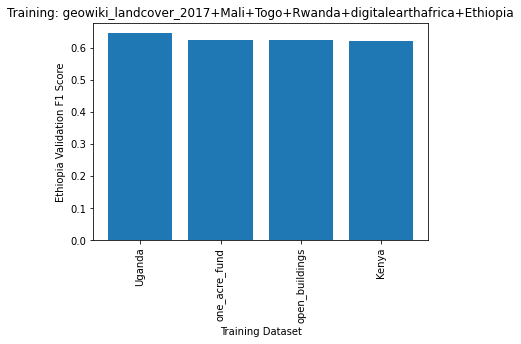

In [125]:
datasets = [d for d in labeled_datasets if d.dataset in [
    "Mali", "Togo", "digitalearthafrica", "geowiki_landcover_2017", "Ethiopia", "Rwanda"
]]
train_on_datasets_plus_one(datasets)

100%|██████████| 56272/56272 [00:18<00:00, 3104.66it/s]


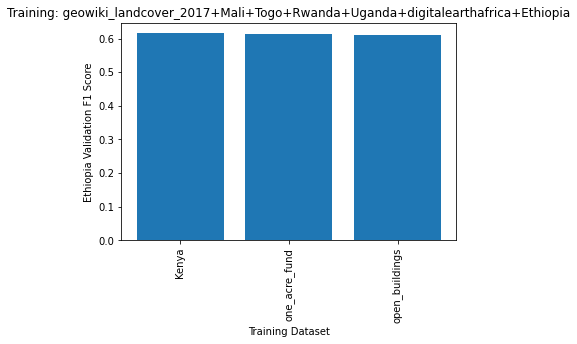

In [126]:
datasets = [d for d in labeled_datasets if d.dataset in [
    "Mali", "Togo", "digitalearthafrica", "geowiki_landcover_2017", "Ethiopia", "Rwanda", "Uganda"
]]
train_on_datasets_plus_one(datasets)

# Testing top combinations

In [134]:
datasets = [d for d in labeled_datasets if d.dataset in [
    "Mali", "Togo", "digitalearthafrica", "geowiki_landcover_2017", "Ethiopia", "Rwanda", "Uganda", "Kenya"
]]
svc_Ethiopia = train_SVC_on_datasets(datasets)
y_pred = svc_Ethiopia.predict(X_val)
f1_score(y_val, y_pred)

100%|██████████| 55065/55065 [00:15<00:00, 3466.72it/s]


0.6153846153846153

In [129]:
datasets = [d for d in labeled_datasets if d.dataset in [
    "Mali", "Togo", "digitalearthafrica", "geowiki_landcover_2017", "Ethiopia", "Rwanda", "Uganda"
]]
svc_Ethiopia = train_SVC_on_datasets(datasets)
y_pred = svc_Ethiopia.predict(X_val)
f1_score(y_val, y_pred)

100%|██████████| 48151/48151 [00:15<00:00, 3137.98it/s]


0.6448979591836734

In [23]:
datasets = [d for d in labeled_datasets if d.dataset in [
    "Mali", "Togo", "digitalearthafrica_eastern", "geowiki_landcover_2017", "Ethiopia", "Rwanda"
]]
svc_Ethiopia = train_SVC_on_datasets(datasets)
y_pred = svc_Ethiopia.predict(X_val)
f1_score(y_val, y_pred)

100%|██████████| 45882/45882 [00:18<00:00, 2466.57it/s]


0.6198830409356725

In [22]:
datasets = [d for d in labeled_datasets if d.dataset in [
    "Mali", "Togo", "digitalearthafrica", "geowiki_landcover_2017", "Ethiopia"
]]
svc_Ethiopia = train_SVC_on_datasets(datasets)
y_pred = svc_Ethiopia.predict(X_val)
f1_score(y_val, y_pred)

100%|██████████| 41143/41143 [00:17<00:00, 2352.09it/s]


0.5789473684210527

In [ ]:
# Avoiding Uganda, Kenya, one_acre_fund, open_buildings dataset, gives better results with SVC